<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# News Article Classification


Today, you are a machine learning engineer at [Upday](https://www.upday.com/home), a news app. The engine behind the app processes almost 100k news articles every day in many languages and context. In order to connect people with the right content, we need to know what the articles are about. 

The job here is to build a classifier that identify the category of an article accurately that will be fed into the recommendation algorithms of the app for better personalized content for the readers. 

You will first train a Transformer from scratch; then fine-tune a pre-trained Transformer model for text classification using 🤗; and compare performances using the same test data set.

## Learning objectives


By the end of this session, you will be able to:
- Understand how Transformer models work
- Build a Transformer model for text classification from scratch
- Fine-tune a pre-trained Transformer model for text classification using 🤗 

# Task 1. Prepare the data

1. [20 news groups data](http://qwone.com/~jason/20Newsgroups/) is one of the standard datasets in the `scikit-learn`. The 20 newsgroups dataset comprises around 18k newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the two datasets is based upon messages posted before and after a specific date.

    Take a read on its [usage]((https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset)) and load the training and testing datasets into `train` and `test` respectively via `fetch_20newsgroups`.

In [1]:
NUM_LABELS = 20

In [2]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(subset='train') # YOUR CODE HERE
test = fetch_20newsgroups(subset='test')# YOUR CODE HERE

len(test['data'])

7532

In [3]:
type(train['target_names'])

list

1. Explore the data. For example, what is the data type of `train` and `test`? What is the data type of `train['data']`? What is in `train['target_names']`? 

train is of type sklearn.utils.Bunch. The train['data'] is of list type. The train['target_names'] is of list type and contains news type category.  

1. Train / validation / test splits. 

    There are four keys in each data set and we need "data" (the text) and "target" (the category). Extract the "data" and create a `pd.Series` named `X`; and extract the "target" and create a `pd.Series` named `y`. Do the same for the `test` data set, named `X_test` and `y_test`, respectively.

In [4]:
import pandas as pd
#X, y = pd.Series([train['data']]), pd.Series([train['target_names']])
X, y = pd.Series(train['data']), pd.Series(train['target'])  # YOUR CODE HERE
X_test, y_test = pd.Series(test['data']), pd.Series(test['target'])# YOUR CODE HERE
#y_train

Now split `X` and `y` into training and validation sets. Use `train_test_split` from `sklearn.model_selection` to split the data; save 10% of the data for validation and set the random state to 19.

In [5]:
from sklearn.model_selection import train_test_split 
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.1, random_state=19)# YOUR CODE HERE

In [6]:
assert y_train.shape == (10182,)
assert y_valid.shape == (1132,)
assert y_test.shape == (7532,)

1. Convert categorical labels into dummy variables. 

    Use `pd.get_dummies` to convert labels into dummy variables for `y_train`, `y_valid`, `y_test`.

In [7]:
y_train = pd.get_dummies(y_train)# YOUR CODE HERE
y_valid = pd.get_dummies(y_valid)# YOUR CODE HERE
y_test = pd.get_dummies(y_test)# YOUR CODE HERE

In [8]:
y_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
6460,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7945,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9538,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5782,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8464,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5032,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1378,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
757,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
assert y_train.shape == (10182, NUM_LABELS)
assert y_valid.shape == (1132, NUM_LABELS)
assert y_test.shape == (7532, NUM_LABELS)

In [38]:
!pip install tensorflow


# Task 2. Attention is all you need

Recently most of the natural language processing tasks are being dominated by the `Transformer` architecture, introduced in [Attention Is All You Need](https://arxiv.org/abs/1706.03762), which used a simple mechanism called `Neural Attention` as one of its building blocks. As the title suggests this architecture didn't require any recurrent layer. We now build a text classification using Attention and Positional Embeddings.

1. Transformer (attention) Block. 

    The concept of `Neural Attention` is fairly simple; i.e., not all input information seen by a model is equally important to the task at hand. Although this concept has been utilized at various different places as well, e.g., max pooling in ConvNets, but the kind of attention we are looking for should be `context aware`.

    The attention mechanism allows output to focus attention on input while producing output while the self-attention model allows inputs to interact with each other; in other words, calculate attention of all other inputs with respect to one input.

    In the paper, the authors proposed another type of attention mechanism called multi-headed attention which refers to the fact that the outer space of the self attention layer gets factored into a set of independent sub-spaces learned separately, where each subspace is called a "head". **You need to implement the multi-head attention layer**, supplying values for two parameters: `num_heads` and `key_dim`.

    There is a learnable dense projection present after the multi-head attention which enables the layer to actually learn something, as opposed to being a purely stateless transformation. **You need to implement `dense_proj`**, use the `tf.keras.Sequential` to stack two dense layers: 
    
        1. first dense layer with `dense_dim` units and activation function `relu`;
        2. second dense layer with `embed_dim` units and no activation function.

In [11]:
from tensorflow.keras import layers as L
import tensorflow as tf
from tensorflow import keras

class TransformerBlock(L.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential([
            L.Dense(dense_dim, activation='relu'),
            L.Dense(embed_dim)
            ])# YOUR CODE HERE
        self.layernorm1 = L.LayerNormalization()
        self.layernorm2 = L.LayerNormalization()
        super().__init__(**kwargs)
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_confog()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config

2022-08-15 19:39:20.071236: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-15 19:39:20.145998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 19:39:20.146014: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


1. Positional embedding. 

    The idea behind Positional Encoding is fairly simple as well: to give the model access to token order information, therefore we are going to add the token's position in the sentence to each word embedding.

    Thus, one input word embedding will have two components: the usual token vector representing the token independent of any specific context, and a position vector representing the position of the token in the current sequence.

In [12]:
class PositionalEmbedding(L.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        self.token_embeddings = L.Embedding(input_dim, output_dim) # YOUR CODE HERE
        self.position_embeddings = L.Embedding(sequence_length, output_dim) # YOUR CODE HERE
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        super().__init__(**kwargs)
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

1. Define some constants to parameterize the model.

In [13]:
VOCAB_SIZE = 10_000
EMBED_DIM = 256
DENSE_DIM = 32
NUM_HEADS = 2
MAX_LEN = 256

1. Tokenizer. 
    
    The tokenizer is a simple tool to convert a text into a sequence of tokens. It is used to convert the training data into a sequence of integers, which are then used as input to the model. 

    Use `Tokenizer` to create a tokenizer for the training data. Set the `num_words` parameter to the number of words to keep in the vocabulary, and `oov_token` to be `"<unk>"`.

In [15]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words= VOCAB_SIZE, oov_token="<unk>") # YOUR CODE HERE
tokenizer.fit_on_texts(X_train)

1. Pad the sequences. 
    
    The tokenizer outputs a sequence of integers, which are then used as input to the model. However, the model expects a sequence of fixed length. To pad the sequences to the same length, use `sequence.pad_sequences` from `keras.preprocessing`.

    Complete function `preprocess` below to 1) tokenize the texts 2) pad the sequences to the same length.

In [16]:
from keras.preprocessing import sequence

def preprocess(texts, tokenizer, maxlen:int = MAX_LEN):
    seqs = tokenizer.texts_to_sequences(texts)# YOUR CODE HERE
    tokenized_text = keras.preprocessing.sequence.pad_sequences(seqs, maxlen=maxlen)# YOUR CODE HERE
    return tokenized_text

1. Preprocess the data. 
    
    Use `preprocess` to preprocess the training, validation, and test data.

In [17]:
X_train = preprocess(X_train,tokenizer,maxlen=MAX_LEN)# YOUR CODE HERE
X_valid = preprocess(X_valid,tokenizer,maxlen=MAX_LEN)# YOUR CODE HERE
X_test  = preprocess(X_test,tokenizer,maxlen=MAX_LEN)# YOUR CODE HERE

1. Define the model with the following architecture: 

    * Input Layer
    * Positional Embeddings
    * Transformer Block
    * Pooling
    * Dropout
    * Output Layer

    If you are not familiar with keras functional API, take a read [here](https://keras.io/guides/functional_api/).

In [18]:
inputs = keras.Input(shape=(None, ), dtype="int64")
x = PositionalEmbedding(MAX_LEN, VOCAB_SIZE, EMBED_DIM)(inputs)# YOUR CODE HERE
x = TransformerBlock(EMBED_DIM, DENSE_DIM, NUM_HEADS)(x)# YOUR CODE HERE
x = L.GlobalMaxPooling1D()(x)
x = L.Dropout(0.5)(x)
outputs = L.Dense(20, activation='softmax')(x)

model = keras.Model(inputs, outputs)

2022-08-15 19:52:46.214766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-15 19:52:46.219859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 19:52:46.220082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-15 19:52:46.220134: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-15 19:52:46.220180: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

1. Compile model. 

    Use 'adam' for the optimizer and accuracy for metrics, supply the correct value for loss. 

In [19]:
model.compile(
    optimizer='adam',# YOUR CODE HERE
    loss='categorical_crossentropy',# YOUR CODE HERE
    metrics=['accuracy']# YOUR CODE HERE
)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        2625536   
 ionalEmbedding)                                                 
                                                                 
 transformer_block (Transfor  (None, None, 256)        543776    
 merBlock)                                                       
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

1. Add [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) and [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/) to stop training if the model does not improve a set metric after a given number of epochs. 

    Create an `EarlyStopping` object named `es` to stop training if the validation loss does not improve after 5 epochs. Set verbose to display messages when the callback takes an action and set `restore_best_weights` to restore model weights from the epoch with the best value of the monitored metric.
    
    Use `ReduceLROnPlateau` to reduce the learning rate if the validation loss does not improve after 3 epochs. Set verbose to display messages when the callback takes an action and use default values for other parameters.
    

In [21]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)# YOUR CODE HERE
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3,verbose=1, min_lr=0.001)# YOUR CODE HERE

1. Train the model. 
    
    Supply both `EarlyStopping` and `ReduceLROnPlateau` for `callbacks`. Set `epochs` to 100.

In [22]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    callbacks= [es, rlp], # YOUR CODE HERE
    epochs=100
)

Epoch 1/100
319/319 [==============================] - 84s 258ms/step - loss: 3.1524 - accuracy: 0.1788 - val_loss: 1.2381 - val_accuracy: 0.6564 - lr: 0.0010
Epoch 2/100
319/319 [==============================] - 82s 257ms/step - loss: 1.0105 - accuracy: 0.7038 - val_loss: 0.5778 - val_accuracy: 0.8304 - lr: 0.0010
Epoch 3/100
319/319 [==============================] - 81s 254ms/step - loss: 0.3983 - accuracy: 0.8792 - val_loss: 0.5391 - val_accuracy: 0.8507 - lr: 0.0010
Epoch 4/100
319/319 [==============================] - 82s 258ms/step - loss: 0.1470 - accuracy: 0.9580 - val_loss: 0.5011 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 5/100
319/319 [==============================] - 82s 258ms/step - loss: 0.0625 - accuracy: 0.9818 - val_loss: 0.5792 - val_accuracy: 0.8640 - lr: 0.0010
Epoch 6/100
319/319 [==============================] - 86s 270ms/step - loss: 0.0335 - accuracy: 0.9913 - val_loss: 0.5468 - val_accuracy: 0.8746 - lr: 0.0010
Epoch 7/100
319/319 [=========================

1. Evaluate the trained model on the test data. 
    
    Use `evaluate` to evaluate the model on the test data (accuracy will be around 0.77).

In [23]:
# YOUR CODE HERE
model.evaluate(X_test,y_test)

236/236 [==============================] - 30s 128ms/step - loss: 0.9166 - accuracy: 0.7738


[0.9165541529655457, 0.7737652659416199]

1. Visualize both loss and accuracy curves for the training and validation data. 

Text(0.5, 1.0, 'Loss')

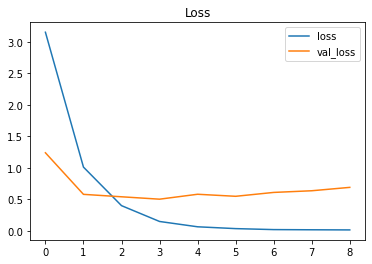

In [25]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

history = pd.DataFrame(history.history)

plt.plot(history[['loss','val_loss']])
plt.legend(['loss','val_loss'])
plt.title("Loss")

Text(0.5, 1.0, 'Accuracy')

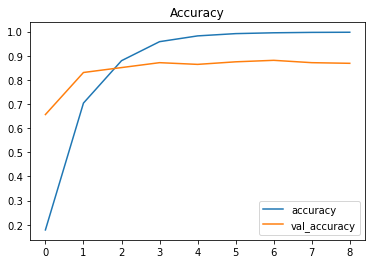

In [27]:
plt.plot(history[['accuracy','val_accuracy']])
plt.legend(['accuracy','val_accuracy'])
plt.title("Accuracy")

# Task 3. Fine-tune pre-trained model via 🤗

Substantial gains can be achieved by pre-training on a large corpus of text followed by fine-tuning a specific task. In this task, we will take advantage of [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/pdf/1910.01108.pdf), [`distillbert-uncased`](https://huggingface.co/distilbert-base-uncased) specifically, and fine-tune it on the 20 Newsgroups dataset.

1. Install [`Transformers`](https://huggingface.co/docs/transformers) and [`datasets`](https://huggingface.co/docs/datasets/index).

In [28]:
! pip install -U -q transformers datasets

1. Import the library and check its version.


In [29]:
import transformers
print(transformers.__version__)

4.21.1


1. Create `Dataset` objects for train / validation / test sets that are better compatible with the `Transformers` API.

    You can first create a `pd.DataFrame` with two fields: `text` and `label` with `data` and `target` from `train`. Then, call the `Dataset.from_pandas()` method to create a `Dataset` object and save it to `train_ds`. 

    Do the same for test set. 

In [37]:
from datasets import Dataset
train_ds = pd.DataFrame({'text':train['data'], 'label':train['target']})# YOUR CODE HERE
train_ds  = Dataset.from_pandas(train_ds) # YOUR CODE HERE
test_ds = pd.DataFrame({'text':test['data'], 'label':test['target']})# YOUR CODE HERE
test_ds  = Dataset.from_pandas(test_ds) # YOUR CODE HERE

1. Cast column `label` as `datasets.features.ClassLabel` object using [`class_encode_column`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.class_encode_column) for both `train_ds` and `test_ds`.

In [38]:
train_ds = train_ds.class_encode_column('label') # YOUR CODE HERE
test_ds = test_ds.class_encode_column('label') # YOUR CODE HERE

Stringifying the column:   0%|          | 0/12 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/12 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

1. Create the validation set by apply [`train_ds.train_test_split()`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.train_test_split). Similarly, set the test size to 0.1, and set the random state to 19. Make sure the split is stratified by column `label`. Save the result to `train_dsd` as the result is a DatasetDict object.

    Here's another way to do train / validation / test split: [ref](https://discuss.huggingface.co/t/how-to-split-main-dataset-into-train-dev-test-as-datasetdict/1090/2)

In [39]:
train_dsd = train_ds.train_test_split(test_size=0.1, stratify_by_column='label', seed=19)# YOUR CODE HERE

In [40]:
train_dsd

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1132
    })
})

1. Yet the 'test' set inside `train_dsd` is meant for validation, the following code will rename the test set to validation and add a new DataSet object for the test set.

In [41]:
train_dsd['validation'] = train_dsd['test']
train_dsd['test'] = test_ds

In [42]:
train_dsd

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7532
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1132
    })
})

1. Load the DistilBERT tokenizer to process the text. 
    
    Use [`AutoTokenizer`](https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/auto#transformers.AutoTokenizer) to load the tokenizer for the given `model_checkpoint`. 

In [50]:
from transformers import AutoTokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)# YOUR CODE HERE

1. Create a preprocessing function to tokenize text, truncate and pad sequences to be no longer than DistilBERT’s maximum input length:

In [51]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=MAX_LEN)

1. Use 🤗 Datasets [map](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.map) function to apply the preprocessing function over the entire dataset. You can speed up the map function by setting `batched=True` to process multiple elements of the dataset at once:

In [54]:
tokenized_text = train_dsd.map(preprocess_function, batched=True) # YOUR CODE HERE

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [55]:
tokenized_text

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7532
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1132
    })
})

1. Use [DataCollatorWithPadding](https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/data_collator#transformers.DataCollatorWithPadding) to create a batch of examples. Set the type of Tensor to return as 'tf' as we will fine-tune the model in TensorFlow.

In [56]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer, return_tensors='tf')# YOUR CODE HERE

In [57]:
data_collator

DataCollatorWithPadding(tokenizer=PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='tf')

In [67]:
tokenized_text["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=20, names=['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

1. To fine-tune a model in TensorFlow, start by converting datasets to the `tf.data.Dataset` format with `to_tf_dataset`. 

    Specify inputs and labels in columns, whether to shuffle the dataset order, batch size, and the data collator:

In [69]:
BATCH_SIZE = 16

tf_train_set = tokenized_text["train"].to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask"],# YOUR CODE HERE
    shuffle=True,# YOUR CODE HERE
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)
tf_validation_set = tokenized_text["validation"].to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask"],# YOUR CODE HERE
    shuffle=True,# YOUR CODE HERE
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    )
tf_test_set = tokenized_text["test"].to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask"],# YOUR CODE HERE
    shuffle=True,# YOUR CODE HERE
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    )

1. Set up an optimizer function, learning rate schedule, and some training hyperparameters:

In [70]:
from transformers import create_optimizer

EPOCHS = 5
batches_per_epoch = len(tokenized_text["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * EPOCHS)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

1. Load DistilBERT with  [TFAutoModelForSequenceClassification](https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/auto#transformers.TFAutoModelForSequenceClassification) along with the number of expected labels:

In [71]:
from transformers import AutoConfig, TFAutoModelForSequenceClassification

config = AutoConfig.from_pretrained("bert-base-cased")
my_bert = TFAutoModelForSequenceClassification.from_config(config) # YOUR CODE HERE

1. Don't forget to configure the model for training with [`compile`](https://keras.io/api/models/model_training_apis/#compile-method):

In [80]:
my_bert.compile(optimizer=optimizer,  metrics=['accuracy'])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


1. Finally, let the fine-tuning start!

    You may run into CoLab's usage limit, feel free to lower the parameter `epochs` to 3; even so, it could take ~10 minutes. 

In [84]:
%%time
# YOUR CODE HERE
# my_bert.fit(
#     tf_train_set, 
#     validation_data=tf_validation_set,
#     callbacks= [es, rlp], # YOUR CODE HERE
#     epochs=3
# )

my_bert.fit(tf_train_set, validation_data=tf_validation_set, epochs=3)

Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node 'tf_bert_for_sequence_classification/bert/embeddings/Gather' defined at (most recent call last):
    File "/home/sireeshunix/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/sireeshunix/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/sireeshunix/anaconda3/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/home/sireeshunix/anaconda3/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/home/sireeshunix/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_354/764672101.py", line 1, in <module>
      get_ipython().run_cell_magic('time', '', '# YOUR CODE HERE\nmy_bert.fit(\n    tf_train_set, \n    validation_data=tf_validation_set,\n    callbacks= [es, rlp], # YOUR CODE HERE\n    epochs=3\n)\n')
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2406, in run_cell_magic
      result = fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/decorator.py", line 232, in fun
      return caller(func, *(extras + args), **kw)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/magic.py", line 187, in <lambda>
      call = lambda f, *a, **k: f(*a, **k)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/magics/execution.py", line 1316, in time
      out = eval(code, glob, local_ns)
    File "<timed eval>", line 2, in <module>
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 1398, in train_step
      y_pred = self(x, training=True)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 1637, in run_call_with_unpacked_inputs
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/transformers/models/bert/modeling_tf_bert.py", line 1650, in call
      outputs = self.bert(
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 1637, in run_call_with_unpacked_inputs
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/transformers/models/bert/modeling_tf_bert.py", line 781, in call
      embedding_output = self.embeddings(
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/transformers/models/bert/modeling_tf_bert.py", line 202, in call
      if input_ids is not None:
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/transformers/models/bert/modeling_tf_bert.py", line 203, in call
      inputs_embeds = tf.gather(params=self.weight, indices=input_ids)
Node: 'tf_bert_for_sequence_classification/bert/embeddings/Gather'
indices[4,201] = 29347 is not in [0, 28996)
	 [[{{node tf_bert_for_sequence_classification/bert/embeddings/Gather}}]] [Op:__inference_train_function_38273]

1. As you are waiting for the fine-tuning to finish, how many parameters does DistilBERT have? How about BERT? What is the world's largest open Multilingual Language Model as of July 2022? (hint: 🌸) 

    YOUR ANSWER HERE

1. Evaluate the model on the test data. 
    
    Use `evaluate` to evaluate the model on the test data (accuracy shall be around 0.84).

In [85]:
bert_loss, bert_acc = my_bert.evaluate(tf_test_set) # YOUR CODE HERE

InvalidArgumentError: Graph execution error:

Detected at node 'tf_bert_for_sequence_classification/bert/embeddings/Gather' defined at (most recent call last):
    File "/home/sireeshunix/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/sireeshunix/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/sireeshunix/anaconda3/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/home/sireeshunix/anaconda3/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/home/sireeshunix/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_354/2500995725.py", line 1, in <module>
      bert_loss, bert_acc = my_bert.evaluate(tf_test_set) # YOUR CODE HERE
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 1501, in test_step
      y_pred = self(x, training=False)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 1637, in run_call_with_unpacked_inputs
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/transformers/models/bert/modeling_tf_bert.py", line 1650, in call
      outputs = self.bert(
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 1637, in run_call_with_unpacked_inputs
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/transformers/models/bert/modeling_tf_bert.py", line 781, in call
      embedding_output = self.embeddings(
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/transformers/models/bert/modeling_tf_bert.py", line 202, in call
      if input_ids is not None:
    File "/home/sireeshunix/anaconda3/lib/python3.9/site-packages/transformers/models/bert/modeling_tf_bert.py", line 203, in call
      inputs_embeds = tf.gather(params=self.weight, indices=input_ids)
Node: 'tf_bert_for_sequence_classification/bert/embeddings/Gather'
indices[3,162] = 29486 is not in [0, 28996)
	 [[{{node tf_bert_for_sequence_classification/bert/embeddings/Gather}}]] [Op:__inference_test_function_41531]

1. Optional. If you are happy with the result, you can save the model to a file. 
    
    One easy way to do it is to use [`save_pretrained()`](https://huggingface.co/docs/transformers/main_classes/model#transformers.PreTrainedModel.save_pretrained) to save the model to a file. Check [Export 🤗 Transformers Models](https://huggingface.co/docs/transformers/serialization) for deployment options.

# Acknowledgement & Reference

- Part of the notebook is adapted from [Text Classification - Attention](https://www.kaggle.com/code/ritvik1909/text-classification-attention)
- Part of the notebook is adapted from [Fine-tune a pretrained model with Hugging Face](https://huggingface.co/docs/transformers/training)
- We used accuracy for metric, check out [Comprehensive Guide to Multiclass Classification Metrics](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd).
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)
- [Hugging Face: State-of-the-Art Natural Language Processing in ten lines of TensorFlow 2.0](https://medium.com/tensorflow/using-tensorflow-2-for-state-of-the-art-natural-language-processing-102445cda54a)
- More readings on Transformers, check the Course Materials section on [CS25: Transformers United](https://web.stanford.edu/class/cs25/)
